In [1]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
from IPython.display import display
%matplotlib inline

In [2]:
def clean_fail_file(root_path, path):
    print('start clean')
    files = next(os.walk(path))[2]
    print('total files: ', len(files))
    record_files = [f for f in files if f[:6] == 'record']
    jpg_file = [f for f in files if f[-3:] == 'jpg']
    remove_count = 0
   
    for idx in record_files:
        try:
            with open(path + idx, 'r') as fp:
                pass
        except:
            idx = idx.split('.')[0].split('_')[1]
            jpg_path = root_path + path + str(idx)+'_cam-image_array_.jpg'
            json_path = root_path + path + 'record_' + str(idx) +'.json'
            print('find: ' + jpg_path)
            print('find: ' + json_path)
            if os.path.exists(jpg_path):
                os.remove(jpg_path)
                print('removed: ' + jpg_path)
                remove_count +=1
            if os.path.exists(json_path):
                os.remove(json_path)  
                print('removed: ' + json_path)
    
    for idx in jpg_file:
        try:
            img = cv2.imread(path + idx, cv2.IMREAD_GRAYSCALE)
            img = cv2.Canny(img,100,400)
            img = np.stack((img,img,img), axis=2)
        except:
            idx = idx.split('_')[0]
            jpg_path = root_path + path + str(idx)+'_cam-image_array_.jpg'
            json_path = root_path + path + 'record_' + str(idx) +'.json'
            print('find: ' + jpg_path)
            print('find: ' + json_path)
            if os.path.exists(jpg_path):
                os.remove(jpg_path)
                print('removed: ' + jpg_path)
                remove_count +=1
            if os.path.exists(json_path):
                os.remove(json_path)  
                print('removed: ' + json_path)
    print('removed: ', remove_count)        
    print('clean done')        

In [3]:
def get_df_from_json(path):
    files = next(os.walk(path))[2]
    record_files = [f for f in files if f[:6] == 'record']
    data = []  
    for j in record_files:
        try:
            with open(path + j, 'r') as fp:
                 data.append(json.load(fp))
        except:
            print('error',j)
    return pd.DataFrame.from_dict(data) 

In [4]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([0, 0, 0])
    upper = np.uint8([100, 100, 100])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([0, 0, 0])
    upper = np.uint8([50, 50, 50])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [5]:
def process_img_real_canny(img):
    loc = img
    try:
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        img = cv2.Canny(img,100,400)
        img = np.stack((img,img,img), axis=2)
        return img
    except:
        print('error: '+ loc)
        img = 'error'
        return img

In [6]:
def process_img_real(loc):
    img = Image.open(loc)
    img = select_rgb_white_yellow(np.array(img))    
    return img             

In [7]:
def process_img_simu_canny(loc):
    img = cv2.imread(loc, cv2.IMREAD_GRAYSCALE)
    img = cv2.Canny(img,50,300)  
    img = np.stack((img,img,img), axis=2)   
    return img             

In [8]:
def process_img_simu(loc):
    img = Image.open(loc)
    for i in range(img.size[0]):    
        for j in range(img.size[1]):
            if j > 50:
                r,g,b = img.getpixel((i,j))
                if(r > 190 and g > 200 and b > 220):
                    img.putpixel((i,j), (34,37,23))
                elif(r > 200 and g > 190 ):  
                    img.putpixel((i,j), (52,33,30))            
            else:
                img.putpixel((i,j), (0,0,0))
  
    img = select_rgb_white_yellow(np.array(img))    
    return img               

In [9]:
def print_images(df, process_func, reverse=False):   
    images = []
    for i,row in df.iterrows():
        pic = None
        if reverse:
            pic = process_func(row["cam/image_array"])
        else:
             pic = mpimg.imread(row["cam/image_array"])
        images.append(pic)
    
    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)    

In [10]:
def check_file_real(df,n=5):
    print(df.shape)
    sample = df.sample(n)
    display(sample.head())
    print_images(sample, process_img_real, False)  
    print_images(sample, process_img_real_canny, True)

In [11]:
def check_file_simu(df,n=5):
    print(df.shape)
    sample = df.sample(n)
    display(sample.head())
    print_images(sample, process_img_simu, False)
    print_images(sample, process_img_simu_canny, True)

In [12]:
def df_process_real(df, path):
    df["img_index"] = df["cam/image_array"].apply(lambda x: int(x.split("_")[0]))
    df["cam/image_array"] = df["cam/image_array"].apply(lambda x: path+x)    
    df = df.sort_values(by=["img_index"])
    return df

In [13]:
def df_process_simu(df, path):
    df["img_index"] = df["cam/image_array"].apply(lambda x: int(x.split("_")[0]))
    df["cam/image_array"] = df["cam/image_array"].apply(lambda x: path+x)    
    df = df.sort_values(by=["img_index"])
    df['user/angle'] = df['user/angle'] * 1.8
    df['user/angle'][df['user/angle'] > 1] = 1
    df['user/angle'][df['user/angle'] < -1] = -1
    
    df["user/throttle"] = max(df["user/throttle"]) * 1.8   
    df["user/throttle"][df["user/throttle"] > 1] = 1.8   
    df["user/throttle"][df["user/throttle"] < -1] = -1
    
    return df

In [14]:
def show_plot(df):
    df = df.sort_values("img_index")
    plt.plot(df["img_index"],df["user/angle"], color='dodgerblue', label='raw steering')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(df["img_index"],df["user/throttle"], color='dodgerblue', label='raw throttle')
    plt.legend(loc='upper left')
    plt.show()

In [15]:
def remove_file(df,path,remoce_dict):
    for k,v in remoce_dict.items():
        range_list = list(range(k,v +1))
        for idx in range_list:            
            jpg_path = root_path + path + str(idx)+'_cam-image_array_.jpg'
            json_path = root_path + path + 'record_' + str(idx) +'.json'
            if os.path.exists(jpg_path):
                os.remove(jpg_path)
            if os.path.exists(json_path):
                os.remove(json_path)
        df = df[~df['img_index'].isin(range_list)]
    return df        

In [16]:
def concate_df(df1,df2):
    max_index_df1 = max(df1["img_index"])
    print('join at:' + str(max_index_df1))
    df2['img_index'] =  df2['img_index'] + max_index_df1  
    concated = pd.concat([df1,df2], axis=0)
    concated = concated.sort_values(by=["img_index"])      
    return concated

In [17]:
def check_single_picture(path, th1=50, th2=350):
    img = Image.open(path)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img = cv2.Canny(img,th1,th2)  
    img = np.stack((img,img,img), axis=2)  
    plt.imshow(img)

In [18]:
root_path = '/home/jovyan/my_data/donkey_car/test_tool/new/'

In [19]:
# left_inner = 'real/tub_left_inner/'
# left_outer = 'real/tub_left_outer/'
# right_inner = 'real/tub_right_inner/'
# right_outer = 'real/tub_right_outer/'
# straight = 'real/tub_straight/'

In [20]:
# simu1 = 'simu/20181017_simu_1/'
# simu2 = 'simu/20181017_simu_2/'
# simu3 = 'simu/20181017_simu_3/'

start clean
total files:  12588
removed:  0
clean done
(6293, 6)


,cam/image_array,timestamp,user/angle,user/mode,user/throttle,img_index
1523,tub_20181020_lighting/2862_cam-image_array_.jpg,None,0.000000,user,0.550000,2862
5928,tub_20181020_lighting/3967_cam-image_array_.jpg,None,0.000000,user,0.550000,3967
3258,tub_20181020_lighting/3353_cam-image_array_.jpg,None,0.000000,user,0.533013,3353
4332,tub_20181020_lighting/3690_cam-image_array_.jpg,None,-0.721702,user,0.550000,3690
5642,tub_20181020_lighting/5537_cam-image_array_.jpg,None,-0.113407,user,0.550000,5537


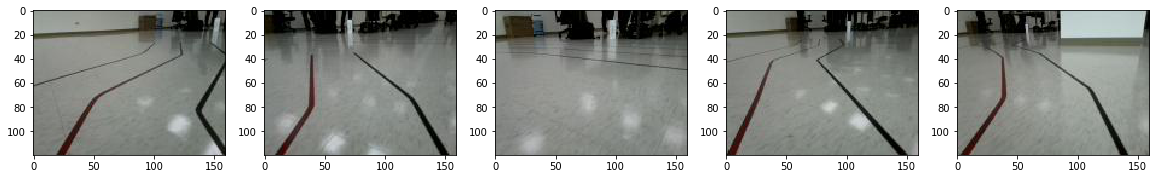

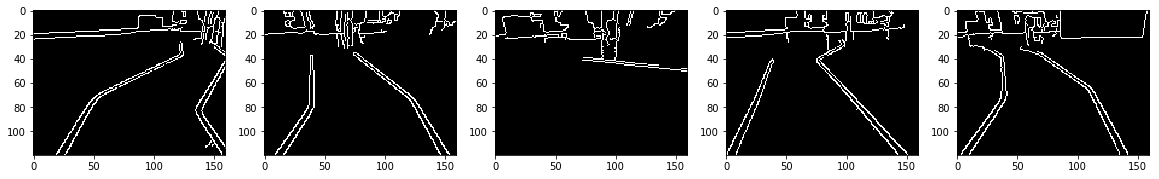

In [21]:
lighting = 'tub_20181020_lighting/'
clean_fail_file(root_path,lighting)
lighting_df = get_df_from_json(lighting)
lighting_df = df_process_real(lighting_df, lighting)
check_file_real(lighting_df,5)

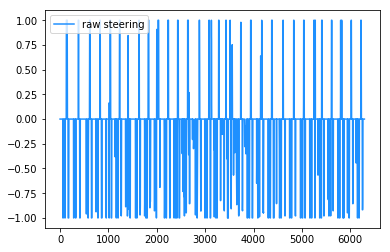

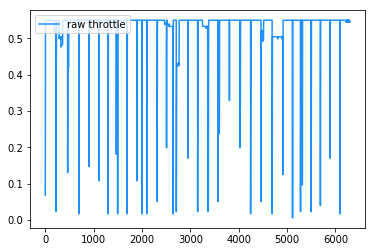

In [22]:
show_plot(lighting_df)

In [24]:
# check_single_picture('real/tub_right_outer/298_cam-image_array_.jpg',50,300)

In [25]:
# 移除數據
# remoce_dict = {
#     0:25     
# }
# df = remove_file(df, path,remoce_dict)

In [23]:
lighting_df.to_csv("real_df.csv", index=False)

In [ ]:
################### 檢查模型誤差

In [24]:
from tensorflow.python.keras.models import Model, load_model

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
# real_model = load_model('real_model')
# simu_model = load_model('simu_model')

In [26]:
def get_predict_data_real(model, img, path):     
    data = process_img_real(img)
    outputs = model.predict(data.reshape((1,) + data.shape))
    return [outputs[0][0][0], outputs[1][0][0]]

In [27]:
def get_predict_data_real_canny(model, img):     
    data = process_img_real_canny(img)
    if data != 'error':
        outputs = model.predict(data.reshape((1,) + data.shape))
        return [outputs[0][0][0], outputs[1][0][0]]
    else:
        return 0,0

In [28]:
def get_predict_data_simu(model, img, path):     
    data = process_img_simu(img)
    outputs = model.predict(data.reshape((1,) + data.shape))
    return [outputs[0][0][0], outputs[1][0][0]]

In [29]:
def get_predict_data_simu_canny(model, img):     
    data = process_img_simu_canny(img)
    outputs = model.predict(data.reshape((1,) + data.shape))
    return [outputs[0][0][0], outputs[1][0][0]]

In [30]:
real_loaded_df = pd.read_csv('real_df.csv')
# simu_loaded_df = pd.read_csv('simu_df_clean.csv')

In [31]:
display(real_loaded_df.head())
# display(simu_loaded_df.head())

,cam/image_array,timestamp,user/angle,user/mode,user/throttle,img_index
0,tub_20181020_lighting/0_cam-image_array_.jpg,NaN,0.0,user,0.068047,0
1,tub_20181020_lighting/1_cam-image_array_.jpg,NaN,0.0,user,0.323215,1
2,tub_20181020_lighting/2_cam-image_array_.jpg,NaN,0.0,user,0.521667,2
3,tub_20181020_lighting/3_cam-image_array_.jpg,NaN,0.0,user,0.550000,3
4,tub_20181020_lighting/4_cam-image_array_.jpg,NaN,0.0,user,0.550000,4


In [32]:
def get_predct(df, model, img_func):
    df["predict"] = df["cam/image_array"].apply(lambda x: img_func(model,x))
    df["steering"] = df["predict"].apply(lambda x: x[0])
    df["throttle"] = df["predict"].apply(lambda x: x[1])
    return df

In [33]:
# real_predicted_df = get_predct(real_loaded_df, real_model, get_predict_data_real_canny, real_path)

In [34]:
# simu_predicted_df = get_predct(simu_loaded_df, simu_model,get_predict_data_simu_canny, simu_path)

In [35]:
# display(real_loaded_df.head())
# display(simu_loaded_df.head())

In [36]:
def show_plot_predict(df):
    plt.plot(df["img_index"],df["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df["img_index"] ,df["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(df["img_index"],df["user/throttle"], color='dodgerblue', label='raw steering')
    plt.plot(df["img_index"] ,df["throttle"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()

In [37]:
def show_plot_predict_mix(df):
    df1 = df[:10000]
    plt.plot(df1["img_index"],df1["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df1["img_index"] ,df1["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
    df2 = df[10001:20000]
    plt.plot(df2["img_index"],df2["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df2["img_index"] ,df2["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
    df3 = df[20001:30000]
    plt.plot(df3["img_index"],df3["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df3["img_index"] ,df3["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
    df4 = df[30001:40000]
    plt.plot(df4["img_index"],df4["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df4["img_index"] ,df4["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
    df5 = df[40001:50000]
    plt.plot(df5["img_index"],df5["user/angle"], color='dodgerblue', label='raw steering')
    plt.plot(df5["img_index"] ,df5["steering"], color='orange', label='predict steering')
    plt.legend(loc='upper left')
    plt.show()
#     plt.plot(df["img_index"],df["user/throttle"], color='dodgerblue', label='raw steering')
#     plt.plot(df["img_index"] ,df["throttle"], color='orange', label='predict steering')
#     plt.legend(loc='upper left')
#     plt.show()

In [38]:
# show_plot_predict(real_predicted_df)

In [39]:
# show_plot_predict(simu_predicted_df)

In [40]:
## switch predict 

In [41]:
# simu_predict_real_df = get_predct(real_loaded_df, simu_model, get_predict_data_real_canny, real_path)

In [42]:
# show_plot_predict(simu_predict_real_df)

In [43]:
# real_predict_simu_df = get_predct(simu_loaded_df, real_model, get_predict_data_simu_canny, simu_path)

In [44]:
# show_plot_predict(real_predict_simu_df)

In [45]:
## mix predict

In [46]:
mix_model = load_model('20181023/transfer_angle2__real_throttle_0.8_model')

In [47]:
start_time = time.time()

mix_real_df = get_predct(real_loaded_df, mix_model, get_predict_data_real_canny)

elapsed_time = time.time() - start_time
peroid = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(peroid)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


00:01:36


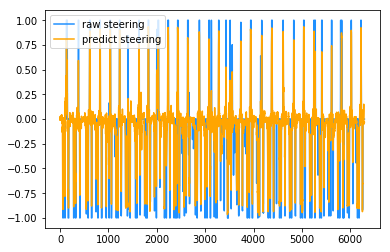

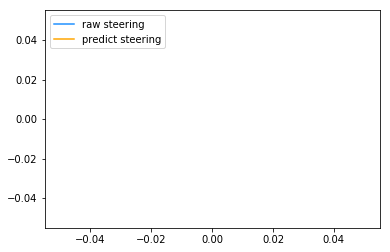

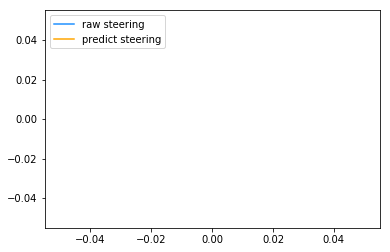

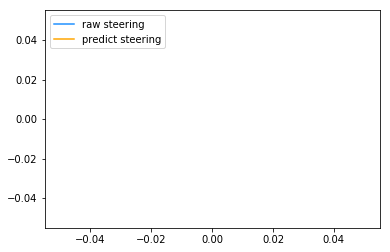

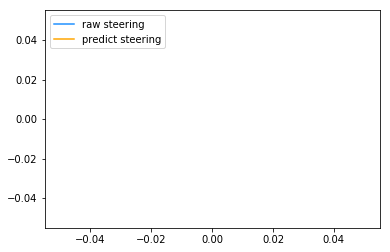

In [48]:
show_plot_predict_mix(mix_real_df)

In [49]:
# start_time = time.time()

# mix_predict_simu_df = get_predct(simu_loaded_df, mix_model, get_predict_data_simu_canny)

# elapsed_time = time.time() - start_time
# peroid = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
# print(peroid)

In [50]:
# show_plot_predict_mix(mix_predict_simu_df)